In [3]:
import networkx as nx
import numpy as np
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import copy

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Linear Threshold Mode

In [27]:
class linear_threshold():
    def __init__(self):
        self.g = nx.DiGraph()
        self.influence = None
    
    def fit(self, g):
        # fit graph with probability
        in_degree = g.in_degree()
        self.num_nodes = g.number_of_nodes()
        self.node_label = [i for i in g.nodes()]
        max_degree = max([d for (n, d) in in_degree])
        self.label2id = {self.node_label[i]: i for i in range(self.num_nodes)}
        self.influence = np.zeros((self.num_nodes, self.num_nodes), dtype=float)
        # init influence 
        for e in g.edges():
            self.influence[self.label2id[e[0]], self.label2id[e[1]]] = 1 / in_degree[e[1]]
        self.g = g
        return g
    
    # diffusion to all possible nodes
    def diffusion_all(self, init_seed, threshold=0.001):
        if(init_seed == []):
            return [], []
        activated_nodes = [self.label2id[name] for name in init_seed]
        old_activated_nodes = copy.deepcopy(activated_nodes)
        # the index represent time t, the value is number of activated nodes in current time
        times = [len(old_activated_nodes)]
        while True:
            new_activated_nodes = []
            for node in old_activated_nodes:
                neighbors = self.influence[node, :].nonzero()[0]
                if(len(neighbors) == 0):
                    continue
                total_influence = 0.0
                for neighbor in neighbors:
                    if(neighbor in activated_nodes):
                        continue
                    precessors = self.influence[:, neighbor].nonzero()[0]
                    for precessor in precessors:
                        if precessor in activated_nodes or precessor in new_activated_nodes:
                            total_influence += self.influence[precessor][neighbor]
                    if(total_influence >= threshold):
                        new_activated_nodes.append(neighbor)
            if len(new_activated_nodes)==0:
                break
            else:
                activated_nodes.extend(new_activated_nodes)
            old_activated_nodes = copy.deepcopy(new_activated_nodes)
            times.append(len(new_activated_nodes))
        return activated_nodes, times
    
    # diffusion to max step
    def diffusion_step(self, init_seed, threshold=0.1, max_step=1):
        if(init_seed == []):
            return [], []
        activated_nodes = [self.label2id[name] for name in init_seed]
        old_activated_nodes = copy.deepcopy(activated_nodes)
        # the index represent time t, the value is number of activated nodes in current time
        times = [len(old_activated_nodes)]
        for _ in range(max_step):
            new_activated_nodes = []
            for node in old_activated_nodes:
                neighbors = self.influence[node, :].nonzero()[0]
                if(len(neighbors) == 0):
                    continue
                total_influence = 0.0
                for neighbor in neighbors:
                    if(neighbor in activated_nodes):
                        continue
                    precessors = self.influence[:, neighbor].nonzero()[0]
                    for precessor in precessors:
                        if precessor in activated_nodes or precessor in new_activated_nodes:
                            total_influence += self.influence[precessor][neighbor]
                    if(total_influence >= threshold):
                        new_activated_nodes.append(neighbor)
            if len(new_activated_nodes)==0:
                break
            else:
                activated_nodes.extend(new_activated_nodes)
            old_activated_nodes = copy.deepcopy(new_activated_nodes)
            times.append(len(new_activated_nodes))
        return activated_nodes, times
    

In [5]:
# read from gml
G = nx.read_gml('PB2020.gml')
G = G.reverse()

In [28]:
lt_model = linear_threshold()
lt_model.fit(G)

In [30]:
# Try Threshold = 0.1, random seeds
N = G.number_of_nodes()
nodes = np.array(G.nodes())
ran_num = np.random.randint(low=0, high=N, size=7)
init_seed = nodes[ran_num]

activated_nodes, times = lt_model.diffusion_all(init_seed, 0.001)
print(times)

[7, 6, 1791, 1]


In [14]:
# Try Threshold = 0.0001 with max_step = 2, random seeds
N = G.number_of_nodes()
nodes = np.array(G.nodes())
ran_num = np.random.randint(low=0, high=N, size=10)
init_seed = nodes[ran_num]

activated_nodes, times = lt_model.diffusion_step(init_seed, 0.001, 2)
print(times)

[10, 6, 224]


In [31]:
# specify nodes 
init_seed = ['principe_giovan', 'Premises187', 'MoralDK', 'proudboy_', 'enrique_tarrio', 'GavinM_ProudBoy', 'proudboy2012']
activated_nodes, times = lt_model.diffusion_all(init_seed, 0.001)
print(times)

[7, 1657, 37, 192]


### Compare the activated nodes' number of thresholds subject to [0, 0.001] as a function of time t.

In [ ]:
# threshold = [1, ... 10]
thresholds = np.arange(0,11)/1
res_act = {}
res_fina = {}
res_times = {}
for th in thresholds:
    #g = init_threshold(th)
    res_fina[th], res_times[th] = lt_model.diffusion_all(init_seed, th)

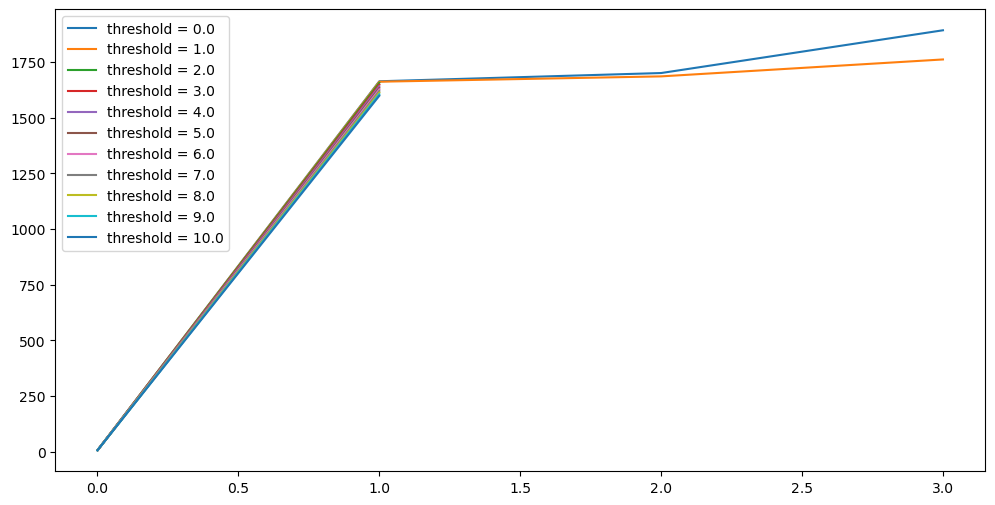

In [217]:
plt.figure(figsize=(12,6))
for key, value in res_times.items():
    sum = []
    s=0
    for v in value:
        s=s+v
        sum.append(s)
    plt.plot(np.arange(len(value)), sum, label="threshold = "+str(key))
plt.legend()
plt.show()

In [223]:
# threshold = [0, ... 1]
thresholds = np.arange(0,11)/10
res_act = {}
res_fina = {}
res_times = {}
for th in thresholds:
    res_fina[th], res_times[th] = lt_model.diffusion_all(init_seed, th)

In [224]:
res_times

{0.0: [7, 1657, 37, 192],
 0.1: [7, 1657, 37, 192],
 0.2: [7, 1657, 37, 192],
 0.3: [7, 1657, 37, 192],
 0.4: [7, 1657, 37, 192],
 0.5: [7, 1657, 37, 192],
 0.6: [7, 1657, 37, 192],
 0.7: [7, 1657, 37, 192],
 0.8: [7, 1657, 37, 192],
 0.9: [7, 1657, 37, 192],
 1.0: [7, 1655, 24, 76]}

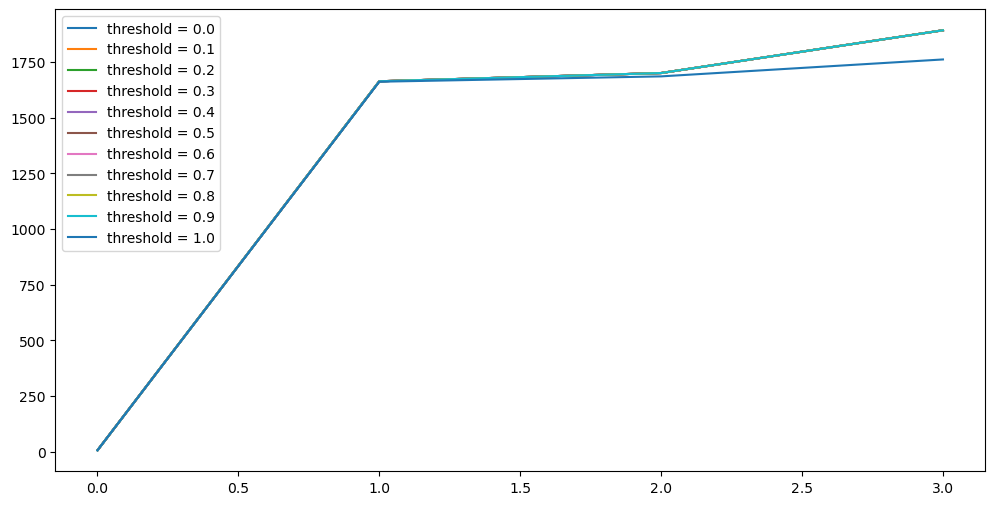

In [225]:
plt.figure(figsize=(12,6))
i=1
for key, value in res_times.items():
    i+=1
    sum = []
    s=0
    for v in value:
        s=s+v
        sum.append(s)
    plt.plot(np.arange(len(value)), sum, label="threshold = "+str(key))
plt.legend()
plt.show()

### Compare the final activated nodes' number as a function of thresholds

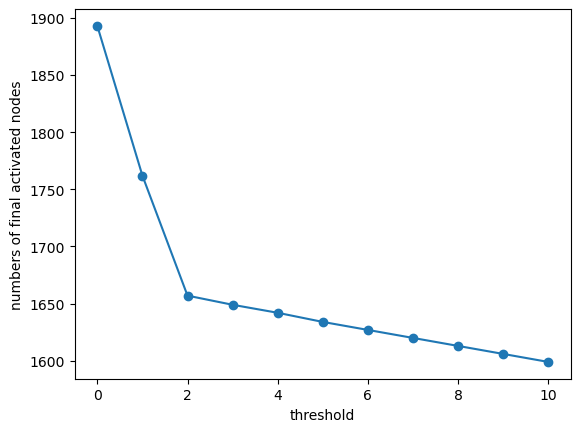

In [209]:
number_activated_nodes = [value for key, value in res_fina.items()]
plt.plot(res_fina.keys(), [len(value) for _, value in res_fina.items()], marker='o')
plt.xlabel("threshold")
plt.ylabel("numbers of final activated nodes")
plt.show()